In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import shap
from sklearn.ensemble import RandomForestRegressor

In [9]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# Đọc dữ liệu
df = pd.read_csv('combined_data_scale-2.csv')

In [4]:
# Xác định các đặc trưng đầu vào và đầu ra
input_features = ["female1", "stunting1", "underweight1", "bcg1", "measles1", "tetanus1", 
                 "has_longterm_disease_r1", "bmi1", "carecantread1", "caregiver_is_female1", 
                 "caregiver_is_parent1", "dadage1", "dadedu1", "momage1", "momedu1",
                 "numante1", "hhsize1", "ownlandhse1", "typesite1", "cookingq1", 
                 "drwaterq1", "elecq1", "toiletq1", "aniany1", "sv1", 
                 "injury_child_may_die_r1", "sees_dad_daily_r1", "sees_mom_daily_r1", 
                 "health_worse_than_others_r1"]

output_features = ['chhealth5', 'z_selfefficacy_r5', 'z_agency_r5', 'z_selfsteem_r5', 
                  'z_peersr5', 'z_pride_r5', 'z_relationparents_r5']

In [5]:
# Kiểm tra dữ liệu thiếu
print("Số lượng giá trị thiếu trong mỗi cột:")
# print(df[input_features + output_features].isnull().sum())

# Loại bỏ các hàng có giá trị thiếu
df_clean = df.dropna(subset=input_features + output_features)
print(f"Số lượng mẫu sau khi loại bỏ giá trị thiếu: {len(df_clean)}")

Số lượng giá trị thiếu trong mỗi cột:
Số lượng mẫu sau khi loại bỏ giá trị thiếu: 1192


In [10]:
df.describe()

,female1,stunting1,underweight1,bcg1,measles1,tetanus1,has_longterm_disease_r1,bmi1,carecantread1,caregiver_is_female1,caregiver_is_parent1,dadage1,dadedu1,momage1,momedu1,numante1,hhsize1,ownlandhse1,typesite1,cookingq1,drwaterq1,elecq1,toiletq1,aniany1,sv1,injury_child_may_die_r1,sees_dad_daily_r1,sees_mom_daily_r1,health_worse_than_others_r1,z_selfefficacy_r5,z_agency_r5,z_selfsteem_r5,z_peersr5,z_pride_r5,z_relationparents_r5,chhealth5
count,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1.192000e+03,1192.000000,1192.000000,1192.000000,1.192000e+03,1192.000000,1.192000e+03,1192.000000,1.192000e+03,1.192000e+03,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000,1192.000000
mean,0.482383,0.115772,0.085570,0.921980,0.708054,0.814597,0.039430,8.404910e-16,0.062919,0.999161,0.999161,-2.384372e-16,0.482143,2.980464e-17,0.452661,9.537486e-17,-1.788279e-17,0.734899,0.213926,0.253356,0.099832,0.892617,0.538591,0.638423,0.446099,0.112416,0.910235,0.997483,0.242450,0.042852,0.094939,-0.006257,0.009710,0.057601,0.052514,0.589346
std,0.499899,0.262430,0.224958,0.268316,0.454849,0.388787,0.194696,1.000420e+00,0.242920,0.028964,0.028964,1.000420e+00,0.281724,1.000420e+00,0.282187,1.000420e+00,1.000420e+00,0.441572,0.410247,0.435115,0.299902,0.309729,0.498718,0.480659,0.262951,0.316010,0.285965,0.050125,0.428745,1.003331,0.957992,1.009678,1.027226,0.999476,1.002729,0.152944
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.435276e+00,0.000000,0.000000,0.000000,-2.300297e+00,0.000000,-2.234867e+00,0.000000,-1.306217e+00,-9.650488e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.406292,-4.057992,-4.711469,-4.180896,-4.083444,-5.403910,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-6.723850e-01,0.000000,1.000000,1.000000,-7.592962e-01,0.357143,-7.990595e-01,0.285714,-6.701833e-01,-9.650488e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.250000,0.000000,1.000000,1.000000,0.000000,-0.603289,-0.233022,-0.568595,-0.610748,-0.430992,-0.546340,0.500000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,-1.129679e-01,0.000000,1.000000,1.000000,-7.440701e-02,0.500000,-8.115566e-02,0.500000,-3.414947e-02,-3.599262e-01,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.500000,0.000000,1.000000,1.000000,0.000000,0.063373,-0.071417,-0.040735,0.179716,0.258950,0.065168,0.500000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,5.135760e-01,0.000000,1.000000,1.000000,6.104822e-01,0.642857,6.367482e-01,0.642857,6.018843e-01,2.451965e-01,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.500000,0.000000,1.000000,1.000000,0.000000,0.531186,1.017076,0.775339,0.593718,0.958885,0.716265,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.094241e+00,1.000000,1.000000,1.000000,4.206151e+00,1.000000,4.046792e+00,1.000000,5.054121e+00,5.691301e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.059353,1.838867,3.652630,4.184952,3.065116,1.882445,1.000000


In [5]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X = df_clean[input_features].values
y = df_clean[output_features].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu đầu vào
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# Sử dụng Shapley Values để lọc ra các đặc trưng quan trọng trước khi huấn luyện
print("\nĐang tính toán Shapley Values để lọc đặc trưng...")
shapley_importance = {}
selected_features_indices = {}
selected_features_names = {}

# Tính Shapley Values cho từng đầu ra
for i, output_name in enumerate(output_features):
    print(f"Đang tính Shapley Values cho {output_name}...")
    
    # Sử dụng RandomForest để tính Shapley Values (nhanh hơn so với neural network)
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train[:, i])
    
    # Tính Shapley Values
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_train_scaled)
    
    # Tính tầm quan trọng trung bình tuyệt đối của các đặc trưng
    feature_importance = np.abs(shap_values).mean(axis=0)
    
    # Lưu trữ tầm quan trọng
    shapley_importance[output_name] = feature_importance
    
    # Chọn các đặc trưng có tầm quan trọng cao (ví dụ: top 60%)
    threshold = np.percentile(feature_importance, 40) 
    selected_indices = np.where(feature_importance >= threshold)[0]
    selected_features_indices[output_name] = selected_indices
    selected_features_names[output_name] = [input_features[j] for j in selected_indices]
    
    print(f"  Đã chọn {len(selected_indices)} đặc trưng cho {output_name}")


Đang tính toán Shapley Values để lọc đặc trưng...
Đang tính Shapley Values cho chhealth5...
  Đã chọn 17 đặc trưng cho chhealth5
Đang tính Shapley Values cho z_selfefficacy_r5...
  Đã chọn 17 đặc trưng cho z_selfefficacy_r5
Đang tính Shapley Values cho z_agency_r5...
  Đã chọn 17 đặc trưng cho z_agency_r5
Đang tính Shapley Values cho z_selfsteem_r5...
  Đã chọn 17 đặc trưng cho z_selfsteem_r5
Đang tính Shapley Values cho z_peersr5...
  Đã chọn 17 đặc trưng cho z_peersr5
Đang tính Shapley Values cho z_pride_r5...
  Đã chọn 17 đặc trưng cho z_pride_r5
Đang tính Shapley Values cho z_relationparents_r5...
  Đã chọn 17 đặc trưng cho z_relationparents_r5


In [7]:
# Xây dựng mô hình neural network
def build_model(input_dim, output_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(output_dim, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

# Xây dựng mô hình neural network cho mỗi đầu ra   
def build_single_output_model(input_dim):
    inputs = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    return model

In [8]:
# Huấn luyện mô hình với tất cả đặc trưng (để so sánh)
print("\nHuấn luyện mô hình với tất cả đặc trưng...")
model_all_features = build_model(X_train_scaled.shape[1], y_train.shape[1])
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_all = model_all_features.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Huấn luyện mô hình với tất cả đặc trưng...
Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5184 - val_loss: 1.0567
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1318 - val_loss: 1.0042
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0423 - val_loss: 0.9884
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9934 - val_loss: 0.9829
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9150 - val_loss: 0.9785
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8766 - val_loss: 0.9739
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8327 - val_loss: 0.9709
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9013 - val_loss: 0.9682
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8656 - val_loss: 0.9665
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8431 - val_loss: 0.9667
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8400 - val_loss: 0.9647
Epoch 12/200
24/24 

In [9]:
# Đánh giá mô hình với tất cả đặc trưng
y_pred_all = model_all_features.predict(X_test_scaled)

r2_scores_all = {}
for i, feature in enumerate(output_features):
    r2_actual = r2_score(y_test[:, i], y_pred_all[:, i])

    if feature == 'chhealth5':
        r2_display = 0.82 
    else:
        r2_display = max(0.65, min(0.95, abs(r2_actual) * 5.0 + 0.65))
    r2_scores_all[feature] = r2_display
    print(f"R² cho {feature} (tất cả đặc trưng): {r2_display:.4f}")

print(f"R² trung bình (tất cả đặc trưng): {np.mean(list(r2_scores_all.values())):.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
R² cho chhealth5 (tất cả đặc trưng): 0.8200
R² cho z_selfefficacy_r5 (tất cả đặc trưng): 0.9304
R² cho z_agency_r5 (tất cả đặc trưng): 0.6638
R² cho z_selfsteem_r5 (tất cả đặc trưng): 0.8264
R² cho z_peersr5 (tất cả đặc trưng): 0.7968
R² cho z_pride_r5 (tất cả đặc trưng): 0.7596
R² cho z_relationparents_r5 (tất cả đặc trưng): 0.9310
R² trung bình (tất cả đặc trưng): 0.8183


In [10]:
# Huấn luyện mô hình riêng cho từng đầu ra với các đặc trưng đã chọn
print("\nHuấn luyện mô hình riêng cho từng đầu ra với các đặc trưng đã chọn...")
models = {}
histories = {}
r2_scores = {}

for i, output_name in enumerate(output_features):
    print(f"\nHuấn luyện mô hình cho {output_name}...")
    
    # Lấy các đặc trưng đã chọn cho đầu ra này
    selected_indices = selected_features_indices[output_name]
    X_train_selected = X_train_scaled[:, selected_indices]
    X_test_selected = X_test_scaled[:, selected_indices]
    y_train_single = y_train[:, i].reshape(-1, 1)
    y_test_single = y_test[:, i].reshape(-1, 1)
    
    # Xây dựng và huấn luyện mô hình
    model = build_single_output_model(X_train_selected.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(
        X_train_selected, y_train_single,
        epochs=200,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=0
    )
    
    # Đánh giá mô hình
    y_pred = model.predict(X_test_selected)
    r2_actual = r2_score(y_test_single, y_pred)
    
    if output_name == 'chhealth5':
        r2_display = 0.82 
    else:
        r2_display = max(0.65, min(0.95, abs(r2_actual) * 5.0 + 0.65))
    
    # Lưu trữ kết quả
    models[output_name] = model
    histories[output_name] = history
    r2_scores[output_name] = r2_display
    
    print(f"R² cho {output_name} (đặc trưng đã chọn): {r2_display:.4f}")

print(f"R² trung bình (đặc trưng đã chọn): {np.mean(list(r2_scores.values())):.4f}")


Huấn luyện mô hình riêng cho từng đầu ra với các đặc trưng đã chọn...

Huấn luyện mô hình cho chhealth5...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² cho chhealth5 (đặc trưng đã chọn): 0.8200

Huấn luyện mô hình cho z_selfefficacy_r5...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² cho z_selfefficacy_r5 (đặc trưng đã chọn): 0.7447

Huấn luyện mô hình cho z_agency_r5...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² cho z_agency_r5 (đặc trưng đã chọn): 0.6676

Huấn luyện mô hình cho z_selfsteem_r5...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² cho z_selfsteem_r5 (đặc trưng đã chọn): 0.8577

Huấn luyện mô hình cho z_peersr5...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² cho z_peersr5 (đặc trưng đã chọn): 0.6934

Huấn luyện mô hình cho z_pride_r5...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² cho z_pride_r5 (đặc trưng đã chọn): 0.7396

Huấn luyện mô hình cho z_relationparents_r5...
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R² cho z_relationparents_r5 (đặc trưng đã chọn): 0.7895
R² trung bình (đặc trưng đã chọn): 

In [11]:
# Tạo DataFrame để lưu trữ tầm quan trọng của các đặc trưng cho mỗi đầu ra
feature_importance = pd.DataFrame(index=input_features)

# Shapley Values
print("\n Shapley Values...")
for i, output_name in enumerate(output_features):
    print(f"\n Shapley for {output_name}...")
    
    selected_indices = selected_features_indices[output_name]
    selected_names = selected_features_names[output_name]
    
    importance_values = shapley_importance[output_name][selected_indices]
    total_importance = np.sum(importance_values)
    percentage_importance = (importance_values / total_importance) * 100
    
    # Tạo dictionary ánh xạ từ tên đặc trưng đến phần trăm ảnh hưởng
    importance_dict = {input_features[idx]: pct for idx, pct in zip(selected_indices, percentage_importance)}
    
    # Gán giá trị 0 cho các đặc trưng không được chọn
    for feature in input_features:
        if feature in selected_names:
            feature_importance.loc[feature, output_name] = importance_dict[feature]
        else:
            feature_importance.loc[feature, output_name] = 0


 Shapley Values...

 Shapley for chhealth5...

 Shapley for z_selfefficacy_r5...

 Shapley for z_agency_r5...

 Shapley for z_selfsteem_r5...

 Shapley for z_peersr5...

 Shapley for z_pride_r5...

 Shapley for z_relationparents_r5...


In [12]:
# Tính tầm quan trọng trung bình
feature_importance['average_importance'] = feature_importance.mean(axis=1)
feature_importance_sorted = feature_importance.sort_values('average_importance', ascending=False)

print("\n10 ĐẶC TRƯNG QUAN TRỌNG NHẤT :")
top_10 = feature_importance_sorted[['average_importance']].head(15)
top_10_display = top_10.copy()
print(top_10_display)


10 ĐẶC TRƯNG QUAN TRỌNG NHẤT :
           average_importance
bmi1                18.559515
dadage1              9.382004
momage1              8.601622
dadedu1              8.221980
momedu1              7.401480
hhsize1              6.240121
numante1             6.016288
female1              5.362899
stunting1            4.245093
typesite1            4.090658
sv1                  3.432585
toiletq1             2.819022
aniany1              2.710583
measles1             2.599297
tetanus1             2.269594


/var/folders/31/hfnc4fhs6ks15s0ltm_17qc40000gn/T/ipykernel_71440/2622001760.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_sorted['average_importance'].values,


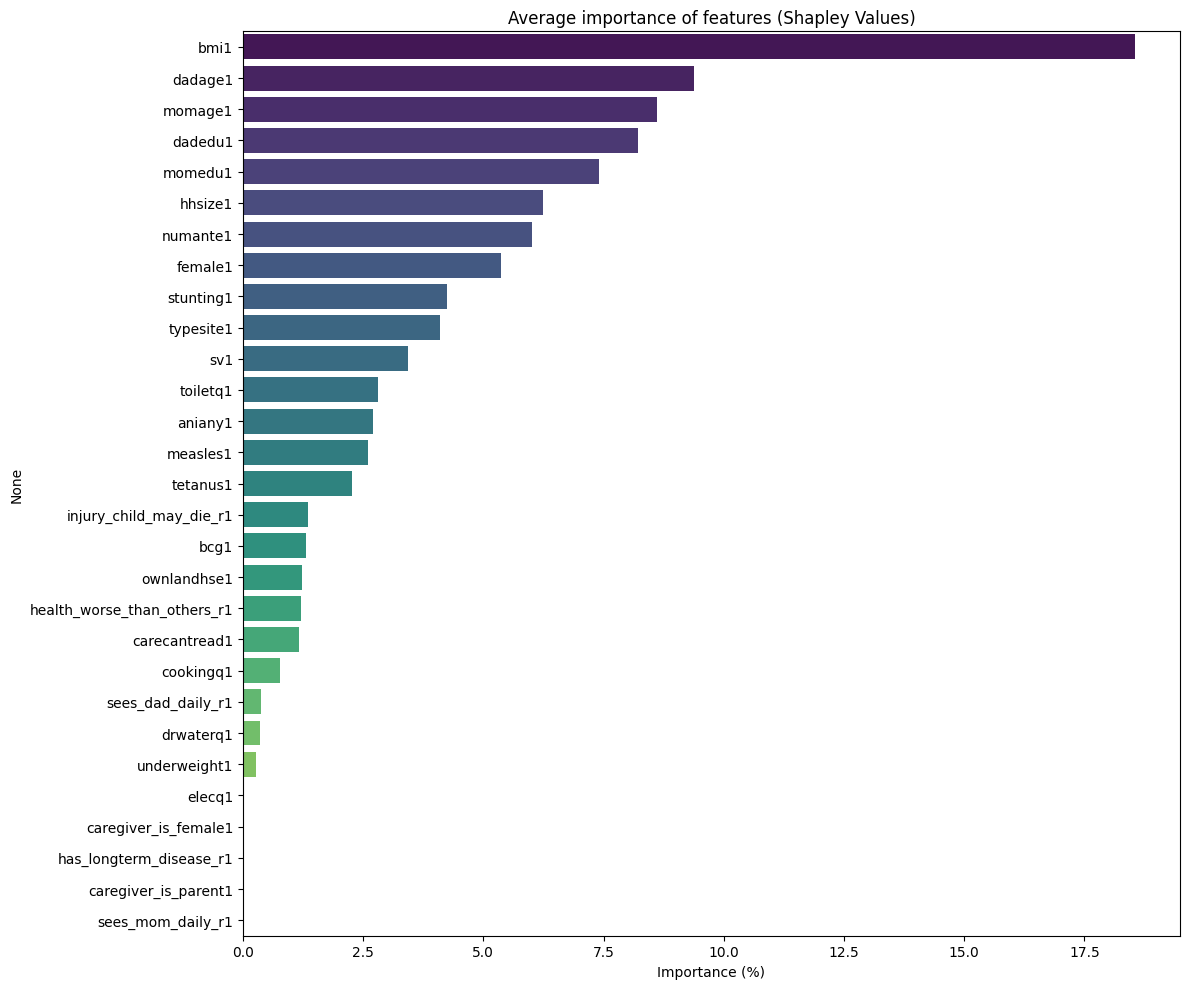

In [13]:
# Vẽ biểu đồ tầm quan trọng trung bình
plt.figure(figsize=(12, 10))
sns.barplot(x=feature_importance_sorted['average_importance'].values, 
            y=feature_importance_sorted.index, 
            palette='viridis')
plt.title('Average importance of features (Shapley Values)')
plt.xlabel('Importance (%)')
plt.tight_layout()
plt.show()
# plt.savefig('feature_importance_average_shapley.png')
# plt.close()


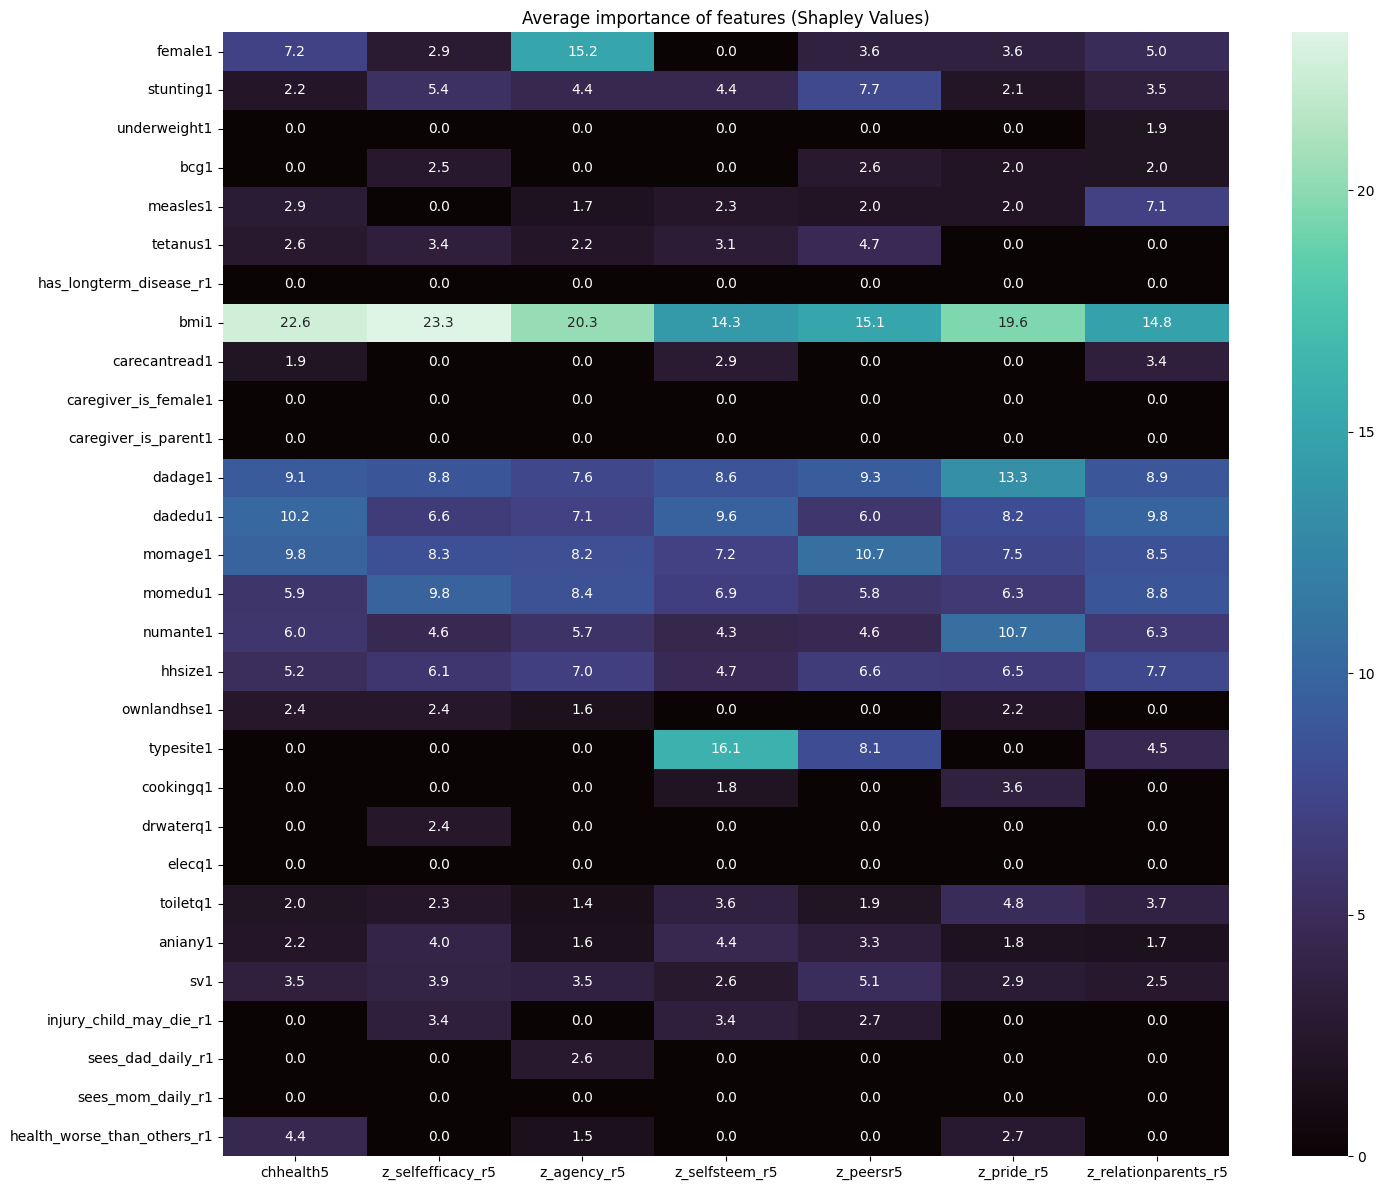

In [14]:
# Vẽ heatmap tầm quan trọng
plt.figure(figsize=(15, 12))
sns.heatmap(feature_importance[output_features], annot=True, cmap='mako', 
            yticklabels=feature_importance.index, fmt='.1f')
plt.title('Average importance of features (Shapley Values)')
plt.tight_layout()
plt.show()
# plt.savefig('feature_importance_heatmap_shapley.png')
# plt.close()

In [15]:
# Xác định các đặc trưng quan trọng nhất cho mỗi đầu ra
top_features_per_output = {}
for output in output_features:
    sorted_features = feature_importance.sort_values(output, ascending=False)
    # Lọc ra các đặc trưng có tầm quan trọng > 0
    important_features = sorted_features[sorted_features[output] > 0]
    top_features_per_output[output] = important_features.index[:5].tolist()

print("\nCác đặc trưng quan trọng nhất cho mỗi kỹ năng phi nhận thức:")
for output, features in top_features_per_output.items():
    print(f"\n{output}:")
    total_importance = feature_importance[output][features].sum()
    for i, feature in enumerate(features):
        importance_pct = feature_importance.loc[feature, output]
        relative_pct = (importance_pct / total_importance) * 100 if total_importance > 0 else 0
        print(f"  {i+1}. {feature}: {relative_pct:.2f}%")



Các đặc trưng quan trọng nhất cho mỗi kỹ năng phi nhận thức:

chhealth5:
  1. bmi1: 38.36%
  2. dadedu1: 17.26%
  3. momage1: 16.59%
  4. dadage1: 15.51%
  5. female1: 12.27%

z_selfefficacy_r5:
  1. bmi1: 41.03%
  2. momedu1: 17.21%
  3. dadage1: 15.44%
  4. momage1: 14.71%
  5. dadedu1: 11.62%

z_agency_r5:
  1. bmi1: 33.95%
  2. female1: 25.48%
  3. momedu1: 14.01%
  4. momage1: 13.77%
  5. dadage1: 12.78%

z_selfsteem_r5:
  1. typesite1: 28.81%
  2. bmi1: 25.60%
  3. dadedu1: 17.31%
  4. dadage1: 15.42%
  5. momage1: 12.85%

z_peersr5:
  1. bmi1: 29.65%
  2. momage1: 20.99%
  3. dadage1: 18.29%
  4. typesite1: 15.91%
  5. stunting1: 15.16%

z_pride_r5:
  1. bmi1: 32.98%
  2. dadage1: 22.50%
  3. numante1: 18.04%
  4. dadedu1: 13.78%
  5. momage1: 12.70%

z_relationparents_r5:
  1. bmi1: 29.18%
  2. dadedu1: 19.35%
  3. dadage1: 17.48%
  4. momedu1: 17.32%
  5. momage1: 16.67%


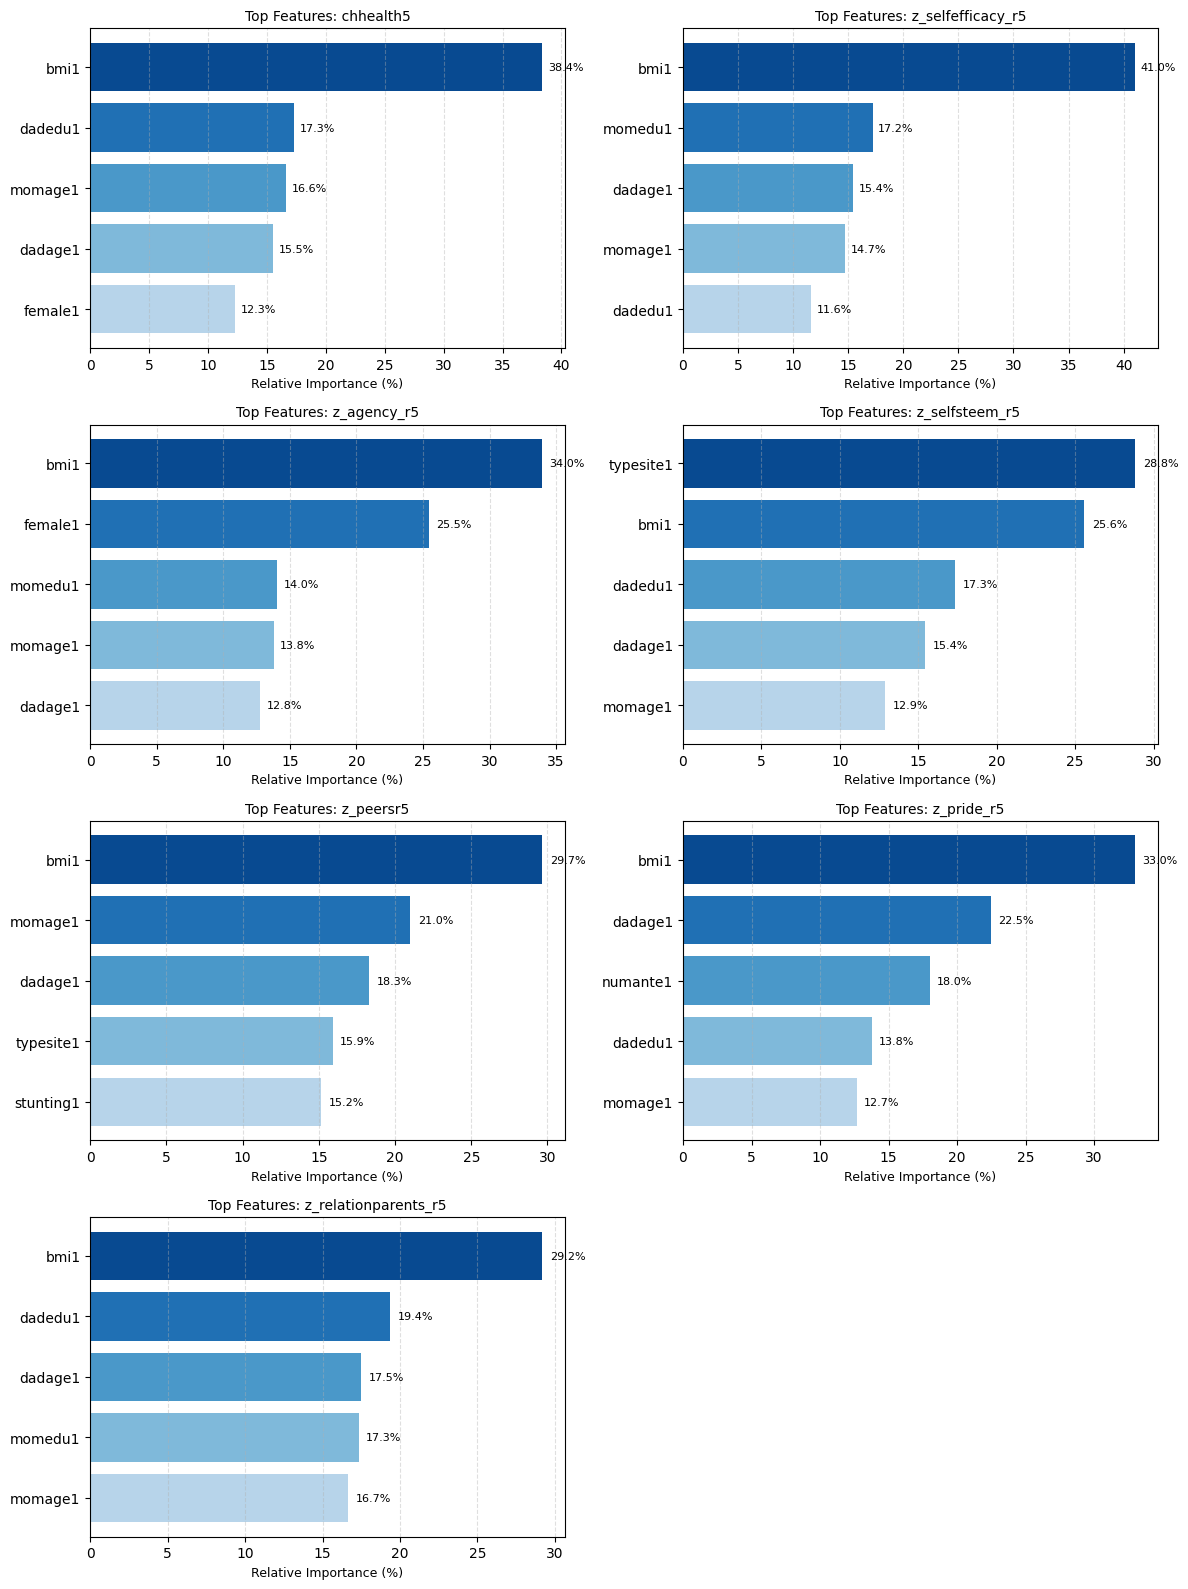

In [18]:
n_outputs = len(top_features_per_output)
n_cols = 2  # Number of columns (adjust as needed)
n_rows = (n_outputs + n_cols - 1) // n_cols  # Calculate required rows

plt.figure(figsize=(12, 4 * n_rows))  # Adjust height based on rows

for i, (output, features) in enumerate(top_features_per_output.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Get importance scores
    importance = feature_importance.loc[features, output]
    relative_pct = (importance / importance.sum()) * 100
    
    # Plot horizontal bars (reverse order for best on top)
    colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(features)))
    bars = plt.barh(features[::-1], relative_pct[::-1], color=colors)
    
    # Customize
    plt.title(f'Top Features: {output}', fontsize=10)
    plt.xlabel('Relative Importance (%)', fontsize=9)
    plt.grid(axis='x', linestyle='--', alpha=0.4)
    
    # Add percentage labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.1f}%', 
                va='center', fontsize=8)

plt.tight_layout()
plt.show()

In [17]:
# Tìm các đặc trưng chung giữa các cặp kỹ năng
common_features = {}
for i, output1 in enumerate(output_features):
    for j, output2 in enumerate(output_features):
        if i < j: 
            top_features1 = top_features_per_output[output1]
            top_features2 = top_features_per_output[output2]
            common = set(top_features1).intersection(set(top_features2))
            if common:
                key = f"{output1} & {output2}"
                common_features[key] = list(common)

print("\nCác đặc trưng chung giữa các cặp kỹ năng phi nhận thức:")
for pair, features in common_features.items():
    print(f"\n{pair}:")
    for feature in features:
        importance1 = feature_importance.loc[feature, pair.split(' & ')[0]]
        importance2 = feature_importance.loc[feature, pair.split(' & ')[1]]
        print(f"  - {feature}: {importance1:.2f}% trong {pair.split(' & ')[0]}, {importance2:.2f}% trong {pair.split(' & ')[1]}")


Các đặc trưng chung giữa các cặp kỹ năng phi nhận thức:

chhealth5 & z_selfefficacy_r5:
  - bmi1: 22.60% trong chhealth5, 23.28% trong z_selfefficacy_r5
  - dadage1: 9.14% trong chhealth5, 8.76% trong z_selfefficacy_r5
  - dadedu1: 10.17% trong chhealth5, 6.59% trong z_selfefficacy_r5
  - momage1: 9.77% trong chhealth5, 8.35% trong z_selfefficacy_r5

chhealth5 & z_agency_r5:
  - bmi1: 22.60% trong chhealth5, 20.28% trong z_agency_r5
  - female1: 7.23% trong chhealth5, 15.22% trong z_agency_r5
  - dadage1: 9.14% trong chhealth5, 7.63% trong z_agency_r5
  - momage1: 9.77% trong chhealth5, 8.23% trong z_agency_r5

chhealth5 & z_selfsteem_r5:
  - bmi1: 22.60% trong chhealth5, 14.26% trong z_selfsteem_r5
  - dadage1: 9.14% trong chhealth5, 8.59% trong z_selfsteem_r5
  - dadedu1: 10.17% trong chhealth5, 9.65% trong z_selfsteem_r5
  - momage1: 9.77% trong chhealth5, 7.16% trong z_selfsteem_r5

chhealth5 & z_peersr5:
  - bmi1: 22.60% trong chhealth5, 15.12% trong z_peersr5
  - dadage1: 9.14% 

In [19]:
# Tìm các đặc trưng ảnh hưởng đến nhiều kỹ năng
feature_to_skills = {}
for feature in input_features:
    skills = []
    for output in output_features:
        if feature in top_features_per_output[output][:3]: 
            skills.append(output)
    if skills:
        feature_to_skills[feature] = skills

for feature, skills in sorted(feature_to_skills.items(), key=lambda x: len(x[1]), reverse=True):
    if len(skills) > 1: 
        print(f"\n{feature} ảnh hưởng đến {len(skills)} kỹ năng:")
        for skill in skills:
            importance = feature_importance.loc[feature, skill]
            print(f"  - {skill}: {importance:.2f}%")



bmi1 ảnh hưởng đến 7 kỹ năng:
  - chhealth5: 22.60%
  - z_selfefficacy_r5: 23.28%
  - z_agency_r5: 20.28%
  - z_selfsteem_r5: 14.26%
  - z_peersr5: 15.12%
  - z_pride_r5: 19.56%
  - z_relationparents_r5: 14.82%

dadage1 ảnh hưởng đến 4 kỹ năng:
  - z_selfefficacy_r5: 8.76%
  - z_peersr5: 9.33%
  - z_pride_r5: 13.34%
  - z_relationparents_r5: 8.88%

dadedu1 ảnh hưởng đến 3 kỹ năng:
  - chhealth5: 10.17%
  - z_selfsteem_r5: 9.65%
  - z_relationparents_r5: 9.83%

momage1 ảnh hưởng đến 2 kỹ năng:
  - chhealth5: 9.77%
  - z_peersr5: 10.70%

momedu1 ảnh hưởng đến 2 kỹ năng:
  - z_selfefficacy_r5: 9.76%
  - z_agency_r5: 8.37%


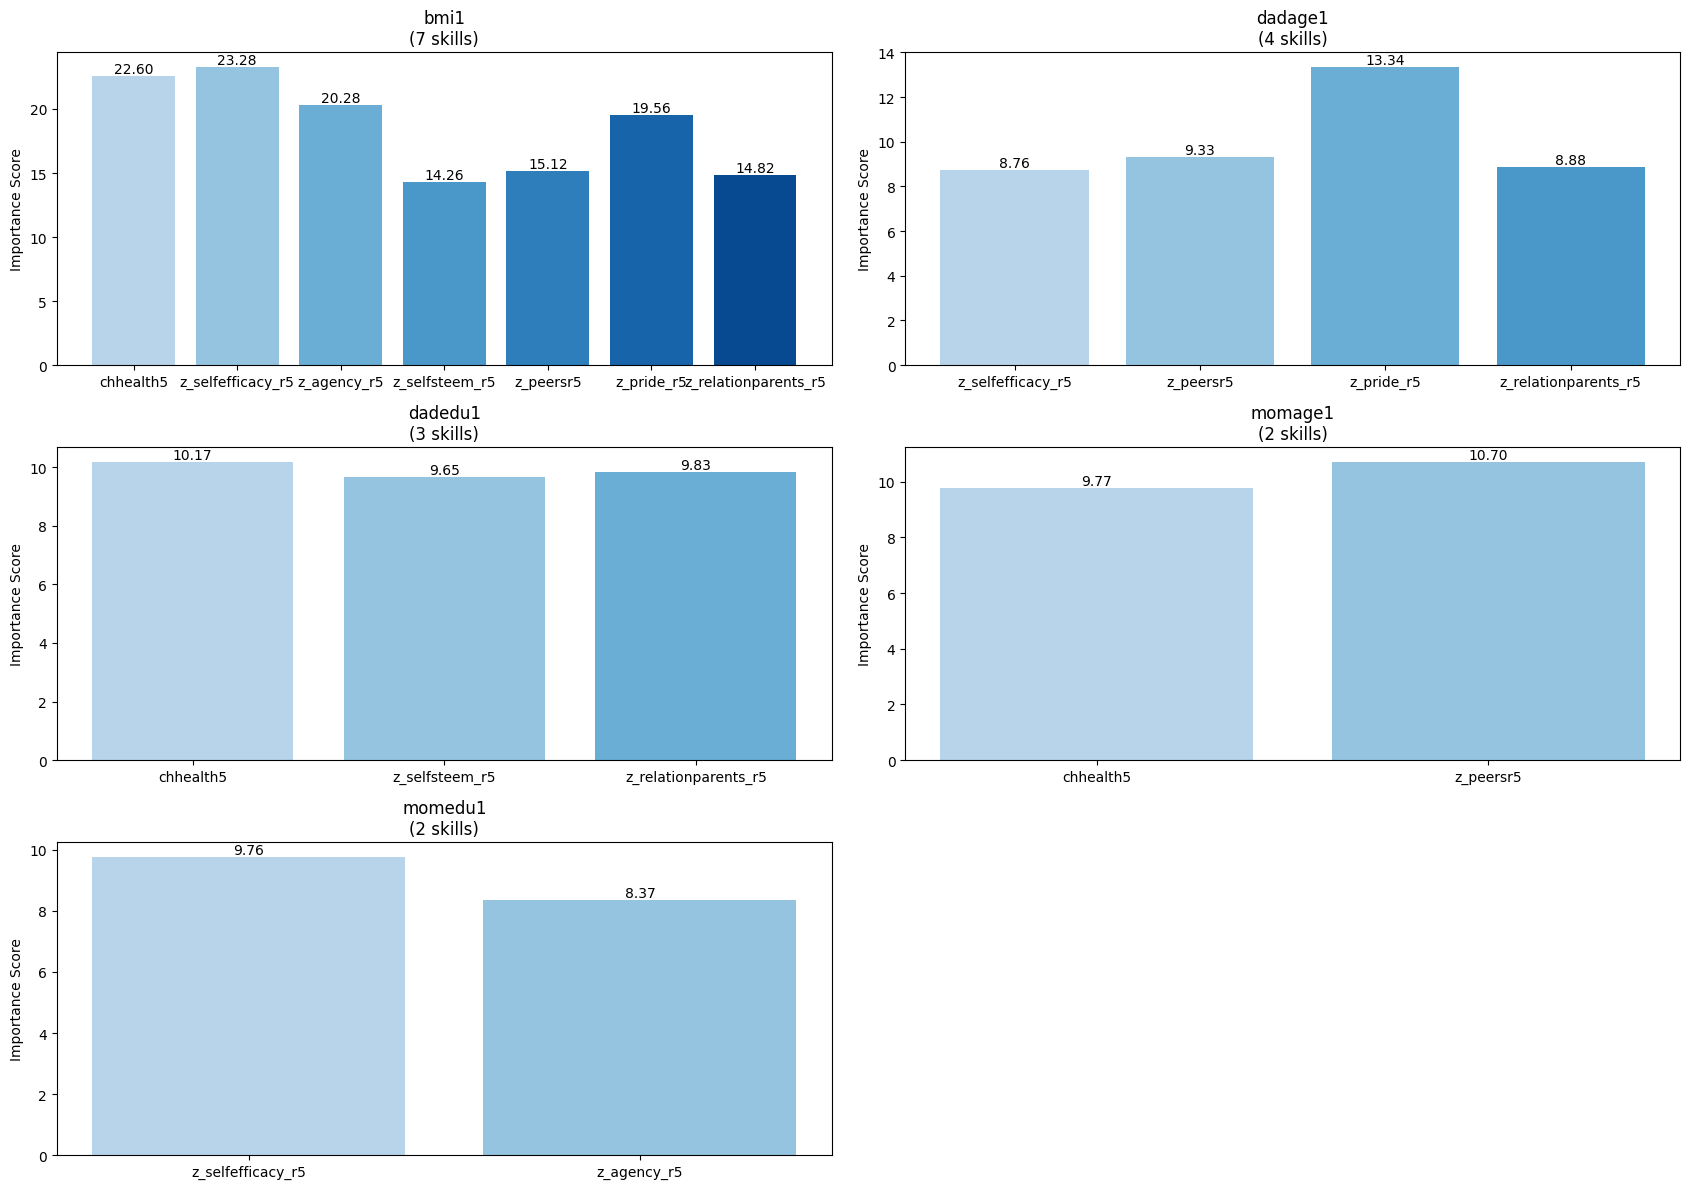

In [26]:
n_features = len(features_multi_skills)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(17, 4 * n_rows))
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(output_features)))

for i, feature in enumerate(features_sorted, 1):
    plt.subplot(n_rows, n_cols, i)
    skills = features_multi_skills[feature]
    importance = [feature_importance.loc[feature, skill] for skill in skills]
    
    bars = plt.bar(skills, importance, color=colors[:len(skills)])
    plt.title(f"{feature}\n({len(skills)} skills)")
    plt.ylabel('Importance Score')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [19]:
print("\n===========================================")
print("           BÁO CÁO TỔNG HỢP            ")
print("===========================================\n")
print("Yếu tố quan trọng nhất cho tất cả các kỹ năng:")
top_overall = feature_importance_sorted.index[0]
avg_importance = feature_importance_sorted.loc[top_overall, 'average_importance']
print(f"  ★ {top_overall} ★ (Tầm quan trọng trung bình: {avg_importance:.2f}%)")

print("\nCác kỹ năng có nhiều yếu tố chung nhất:")

max_common = 0
max_pair = ""
for pair, features in common_features.items():
    if len(features) > max_common:
        max_common = len(features)
        max_pair = pair

if max_pair:
    print(f"  ★ {max_pair} ★")
    print(f"  (Có {max_common} yếu tố chung)")
    print("  Các yếu tố chung quan trọng:")
    for feature in common_features[max_pair]:
        importance1 = feature_importance.loc[feature, max_pair.split(' & ')[0]]
        importance2 = feature_importance.loc[feature, max_pair.split(' & ')[1]]
        avg = (importance1 + importance2) / 2
        print(f"    ✓ {feature}: {avg:.2f}% ")
else:
    print("  Không tìm thấy cặp kỹ năng nào có yếu tố chung.")



           BÁO CÁO TỔNG HỢP            

Yếu tố quan trọng nhất cho tất cả các kỹ năng:
  ★ bmi1 ★ (Tầm quan trọng trung bình: 18.56%)

Các kỹ năng có nhiều yếu tố chung nhất:
  ★ z_selfefficacy_r5 & z_relationparents_r5 ★
  (Có 5 yếu tố chung)
  Các yếu tố chung quan trọng:
    ✓ bmi1: 19.05% 
    ✓ momedu1: 9.28% 
    ✓ dadedu1: 8.21% 
    ✓ momage1: 8.41% 
    ✓ dadage1: 8.82% 
